# 🧹 Notebook 2: Text Preprocessing

## 1. Setup

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pavannn16/BERTopic-arXiv-Analysis/blob/main/notebooks/02_preprocessing.ipynb)

---

**Purpose:** Clean and normalize arXiv abstracts for topic modeling.

**Time:** ~1 minute

In [7]:
# ============================================================
# PROJECT SETUP - Config-based with Train/Infer Modes
# ============================================================
!pip install pyyaml -q

import os
import yaml
from pathlib import Path

# Clone repo if running on Colab
if 'google.colab' in str(get_ipython()) and not os.path.exists('/content/BERTopic-arXiv-Analysis'):
    !git clone https://github.com/pavannn16/BERTopic-arXiv-Analysis.git /content/BERTopic-arXiv-Analysis

# Load configuration
def load_config():
    config_paths = ['config.yaml', '../config.yaml', '/content/BERTopic-arXiv-Analysis/config.yaml']
    for path in config_paths:
        if os.path.exists(path):
            with open(path, 'r') as f:
                return yaml.safe_load(f), path
    return None, None

config, config_path = load_config()
if config:
    print(f"Loaded config from {config_path}")
else:
    config = {'mode': 'infer'}

MODE = config.get('mode', 'infer')
print(f"Mode: {MODE.upper()}")

# Setup paths
if 'google.colab' in str(get_ipython()):
    if MODE == 'train':
        from google.colab import drive
        drive.mount('/content/drive')
        PROJECT_PATH = '/content/drive/MyDrive/BERTopic-arXiv-Analysis'
        print("TRAIN mode: Personal Drive mounted")
    else:
        PROJECT_PATH = '/content/BERTopic-arXiv-Analysis'
        print("INFER mode: Using data from cloned repo")
else:
    PROJECT_PATH = str(Path(os.getcwd()).parent) if 'notebooks' in os.getcwd() else os.getcwd()
    print("Running locally")

for folder in ['data/raw', 'data/processed', 'data/embeddings', 'models', 'results']:
    os.makedirs(f'{PROJECT_PATH}/{folder}', exist_ok=True)

print(f"Project path: {PROJECT_PATH}")

Loaded config from ../config.yaml
Mode: INFER
Running locally
Project path: /Users/pavan/Downloads/CSULA SEM1/AI/Code Assignments/BERTopic-arXiv-Analysis


In [8]:
# Import libraries
import pandas as pd
import numpy as np
import re
import unicodedata
from collections import Counter

print("Libraries imported!")

Libraries imported!


## 2. Load Raw Data

In [9]:
# Load raw data
raw_path = f"{PROJECT_PATH}/data/raw/arxiv_cs_ai_raw.csv"
df = pd.read_csv(raw_path)

print(f"Loaded {len(df)} papers")
print(f"Columns: {list(df.columns)}")
df.head()

Loaded 20000 papers
Columns: ['arxiv_id', 'title', 'abstract', 'authors', 'date', 'year_month', 'url', 'categories', 'primary_category', 'title_len', 'abstract_len']


,arxiv_id,title,abstract,authors,date,year_month,url,categories,primary_category,title_len,abstract_len
0,2512.02987v1,Fine-Tuned Large Language Models for Logical T...,Recent advances in natural language processing...,"Muyu Pan, Dheeraj Kodakandla, Mahfuza Farooque",2025-12-02,2025-12,http://arxiv.org/abs/2512.02987v1,"cs.CL, cs.AI",cs.CL,97,1079
1,2512.02978v1,"Rethinking Generalized BCIs: Benchmarking 340,...",Robust decoding and classification of brain pa...,"Paul Barbaste, Olivier Oullier, Xavier Vasques",2025-12-02,2025-12,http://arxiv.org/abs/2512.02978v1,"q-bio.NC, cs.AI, cs.HC, cs.LG",q-bio.NC,116,1674
2,2512.02966v1,Lumos: Let there be Language Model System Cert...,"We introduce the first principled framework, L...","Isha Chaudhary, Vedaant Jain, Avaljot Singh, K...",2025-12-02,2025-12,http://arxiv.org/abs/2512.02966v1,"cs.PL, cs.AI, cs.MA",cs.PL,55,1693
3,2512.02942v1,Benchmarking Scientific Understanding and Reas...,The next frontier for video generation lies in...,"Lanxiang Hu, Abhilash Shankarampeta, Yixin Hua...",2025-12-02,2025-12,http://arxiv.org/abs/2512.02942v1,"cs.CV, cs.AI",cs.CV,97,1519
4,2512.02932v1,EGGS: Exchangeable 2D/3D Gaussian Splatting fo...,Novel view synthesis (NVS) is crucial in compu...,"Yancheng Zhang, Guangyu Sun, Chen Chen",2025-12-02,2025-12,http://arxiv.org/abs/2512.02932v1,"cs.CV, cs.AI",cs.CV,97,1117


## 3. Text Cleaning Functions

In [10]:
def clean_text(text):
    """
    Clean and normalize text from arXiv abstracts.

    Steps:
    1. Unicode normalization
    2. Remove LaTeX math expressions
    3. Remove LaTeX commands
    4. Remove URLs
    5. Remove arXiv references
    6. Remove common boilerplate phrases
    7. Normalize whitespace
    """
    if not isinstance(text, str):
        return ""

    # 1. Unicode normalization
    text = unicodedata.normalize("NFKC", text)

    # 2. Remove LaTeX math expressions
    text = re.sub(r'\$[^$]+\$', ' ', text)  # Inline math $...$
    text = re.sub(r'\\\[[^\]]+\\\]', ' ', text)  # Display math \[...\]
    text = re.sub(r'\\begin\{equation\}.*?\\end\{equation\}', ' ', text, flags=re.DOTALL)
    text = re.sub(r'\\begin\{align\}.*?\\end\{align\}', ' ', text, flags=re.DOTALL)

    # 3. Remove LaTeX commands
    text = re.sub(r'\\[a-zA-Z]+\{[^}]*\}', '', text)  # \command{...}
    text = re.sub(r'\\[a-zA-Z]+', '', text)  # \command
    text = re.sub(r'\{|\}', '', text)  # Stray braces

    # 4. Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)

    # 5. Remove arXiv references
    text = re.sub(r'arXiv:\d+\.\d+', '', text)

    # 6. Remove common boilerplate (start of abstract)
    boilerplate_patterns = [
        r'^in this paper,?\s*',
        r'^in this work,?\s*',
        r'^this paper presents\s*',
        r'^this work presents\s*',
        r'^we present\s*',
        r'^we propose\s*',
        r'^we introduce\s*',
    ]
    for pattern in boilerplate_patterns:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)

    # 7. Normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()

    return text


# Test the cleaning function
test_text = """
In this paper, we propose a novel approach to neural network optimization.
Our method achieves $O(n^2)$ complexity using \\textbf{gradient descent}.
See our code at https://github.com/example/repo and arXiv:2301.12345.
"""

print("Original:")
print(test_text)
print("\nCleaned:")
print(clean_text(test_text))

Original:

In this paper, we propose a novel approach to neural network optimization.
Our method achieves $O(n^2)$ complexity using \textbf{gradient descent}.
See our code at https://github.com/example/repo and arXiv:2301.12345.


Cleaned:
In this paper, we propose a novel approach to neural network optimization. Our method achieves complexity using . See our code at and .


## 4. Apply Preprocessing

In [11]:
# Clean title and abstract
print("Cleaning text...")
df['title_clean'] = df['title'].apply(clean_text)
df['abstract_clean'] = df['abstract'].apply(clean_text)

# Combine title and abstract for topic modeling
# The title provides important keywords, abstract provides context
df['text'] = df['title_clean'] + ". " + df['abstract_clean']

print("Text cleaning complete!")
print(f"\nSample cleaned text:")
print(df['text'].iloc[0][:500])

Cleaning text...
Text cleaning complete!

Sample cleaned text:
Fine-Tuned Large Language Models for Logical Translation: Reducing Hallucinations with Lang2Logic. Recent advances in natural language processing (NLP), particularly large language models (LLMs), have motivated the automatic translation of natural language statements into formal logic without human intervention. This enables automated reasoning and facilitates debugging, finding loop invariants, and adhering to specifications in software systems. However, hallucinations-incorrect outputs generat


In [12]:
# Calculate text lengths
df['text_len'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

print("Text length statistics:")
print(df[['text_len', 'word_count']].describe())

Text length statistics:
         text_len    word_count
count  20000.0000  20000.000000
mean    1414.1818    188.008500
std      313.7889     42.282691
min       85.0000     12.000000
25%     1203.0000    159.000000
50%     1414.0000    187.000000
75%     1639.0000    217.000000
max     3508.0000    491.000000
         text_len    word_count
count  20000.0000  20000.000000
mean    1414.1818    188.008500
std      313.7889     42.282691
min       85.0000     12.000000
25%     1203.0000    159.000000
50%     1414.0000    187.000000
75%     1639.0000    217.000000
max     3508.0000    491.000000


## 5. Quality Filtering

In [13]:
# Filter out very short texts (likely incomplete or corrupted)
MIN_TEXT_LENGTH = 100
MIN_WORD_COUNT = 20

initial_count = len(df)

# Apply filters
df = df[df['text_len'] >= MIN_TEXT_LENGTH]
df = df[df['word_count'] >= MIN_WORD_COUNT]

# Remove duplicates by arxiv_id
df = df.drop_duplicates(subset=['arxiv_id'])

# Reset index
df = df.reset_index(drop=True)

removed_count = initial_count - len(df)
print(f"Removed {removed_count} documents (too short or duplicates)")
print(f"Remaining documents: {len(df)}")

Removed 2 documents (too short or duplicates)
Remaining documents: 19998


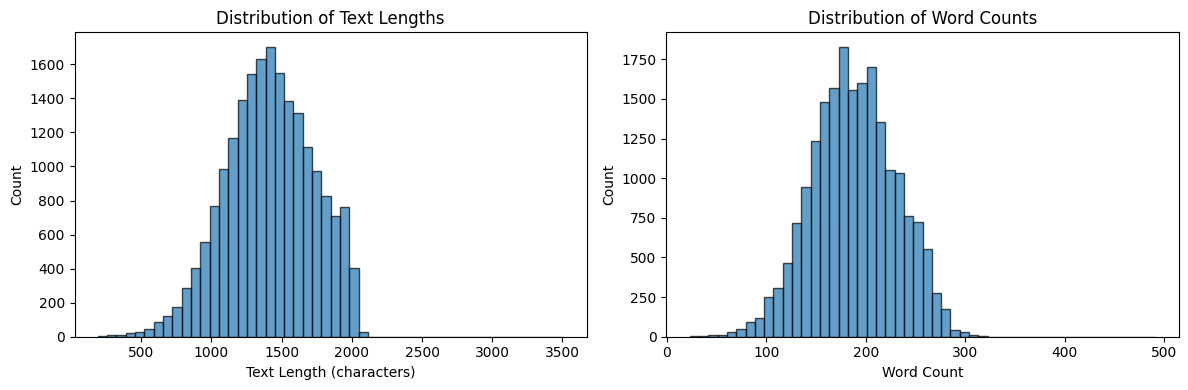

In [14]:
# Check text length distribution after filtering
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df['text_len'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Text Length (characters)')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Text Lengths')

axes[1].hist(df['word_count'], bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Word Counts')

plt.tight_layout()
plt.savefig(f"{PROJECT_PATH}/results/text_length_distribution.png", dpi=150)
plt.show()

## 6. Exploratory Analysis

In [15]:
# Most common words (quick exploration)
from collections import Counter
import string

# Simple tokenization
all_words = []
for text in df['text']:
    words = text.lower().split()
    # Remove punctuation and short words
    words = [w.strip(string.punctuation) for w in words if len(w) > 2]
    all_words.extend(words)

# Count words
word_counts = Counter(all_words)

# Remove common stopwords for display
stopwords = {'the', 'and', 'for', 'are', 'with', 'that', 'this', 'from',
             'can', 'our', 'has', 'have', 'been', 'which', 'their', 'more',
             'these', 'such', 'than', 'also', 'based', 'use', 'using'}

filtered_counts = {k: v for k, v in word_counts.items() if k not in stopwords}

print("Top 30 most common words (excluding stopwords):")
for word, count in Counter(filtered_counts).most_common(30):
    print(f"  {word}: {count}")

Top 30 most common words (excluding stopwords):
  models: 27095
  model: 18223
  data: 15205
  learning: 14925
  language: 13257
  framework: 13142
  performance: 12349
  reasoning: 12310
  llms: 11657
  while: 11058
  large: 10467
  across: 10452
  methods: 8755
  tasks: 8597
  training: 8340
  results: 7587
  propose: 7516
  through: 7389
  systems: 7149
  approach: 7132
  into: 7033
  both: 6728
  generation: 6689
  existing: 6656
  demonstrate: 6504
  however: 6452
  accuracy: 6332
  introduce: 6005
  evaluation: 5836
  method: 5816


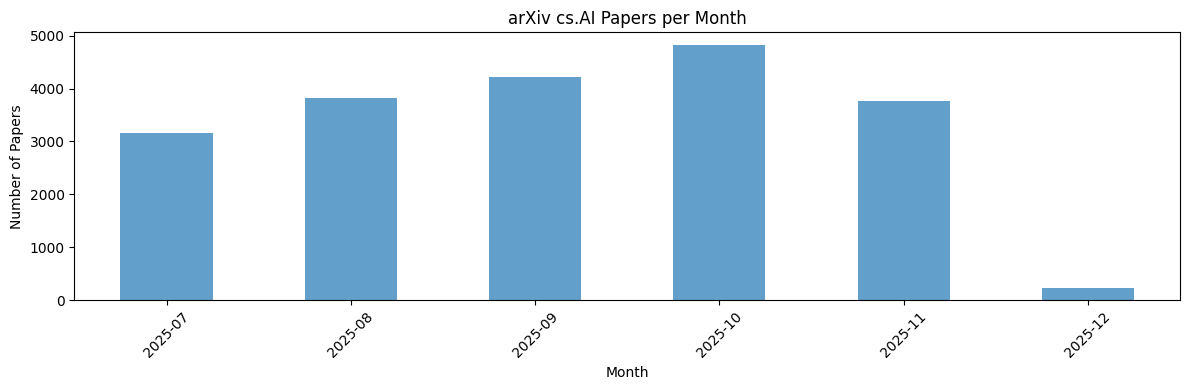

In [16]:
# Papers over time
papers_per_month = df['year_month'].value_counts().sort_index()

plt.figure(figsize=(12, 4))
papers_per_month.plot(kind='bar', alpha=0.7)
plt.xlabel('Month')
plt.ylabel('Number of Papers')
plt.title('arXiv cs.AI Papers per Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{PROJECT_PATH}/results/papers_per_month.png", dpi=150)
plt.show()

## 7. Save Processed Data

In [17]:
# ============================================================
# Save processed data (TRAIN mode only)
# ============================================================
if MODE == 'infer':
    print("INFER mode: Skipping save (processed data already exists)")
    print(f"Existing data at: {PROJECT_PATH}/data/processed/arxiv_cs_ai_processed.csv")
else:
    # Select columns to save
    columns_to_save = ['arxiv_id', 'title', 'abstract', 'title_clean', 'abstract_clean',
                       'text', 'authors', 'date', 'year_month', 'url', 'categories']

    df_save = df[columns_to_save].copy()

    # Save processed data
    processed_path = f"{PROJECT_PATH}/data/processed/arxiv_cs_ai_processed.csv"
    df_save.to_csv(processed_path, index=False)

    print(f"Saved {len(df_save)} processed documents to:")
    print(f"  {processed_path}")

INFER mode: Skipping save (processed data already exists)
Existing data at: /Users/pavan/Downloads/CSULA SEM1/AI/Code Assignments/BERTopic-arXiv-Analysis/data/processed/arxiv_cs_ai_processed.csv


In [18]:
# ============================================================
# Save documents list (TRAIN mode only)
# ============================================================
if MODE == 'infer':
    print("INFER mode: Skipping documents.json save")
else:
    # Also save just the text column as a list (for BERTopic)
    documents = df['text'].tolist()

    import json
    docs_path = f"{PROJECT_PATH}/data/processed/documents.json"
    with open(docs_path, 'w') as f:
        json.dump(documents, f)

    print(f"Saved {len(documents)} documents to {docs_path}")

INFER mode: Skipping documents.json save
